# Setup

In [ ]:
!pip install scipy==1.12

#modeling libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Bidirectional

#processing libraries
import gc
import psutil
import multiprocessing
import re
import tqdm
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
import zipfile
import io
import os
import ast
import gensim
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
import string
stop_words = set(stopwords.words("english"))



# functions
def extract_main_headline(row_headline):
    try:
        # Ensure the row_headline is a valid string representation of a dictionary
        if isinstance(row_headline, str):
            headline_dict = ast.literal_eval(row_headline)
            return headline_dict.get('main')
    except (ValueError, SyntaxError):
        # Return None or a default value if parsing fails
        return None

# Function to split the dataset based on years
def split_data_by_year(df, dropnulls = False):
    if dropnulls==True:
        df = df.dropna()
    training_set = df[df['year'] < 2023]
    validation_set = df[df['year'] == 2023]
    test_set = df[df['year'] == 2024]

    return training_set, validation_set, test_set

class BlockingTimeSeriesSplit():
    def __init__(self, n_splits):
        self.n_splits = n_splits

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits

    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)

        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int(0.8 * (stop - start)) + start
            yield indices[start: mid], indices[mid + margin: stop]

from nltk.tokenize import word_tokenize
import string


def clean_text(texts):
    cleaned = [' '.join([word for word in word_tokenize(text)
                       if word.lower() not in stop_words
                       and word not in string.punctuation])
            for text in texts]

    # Tokenize each cleaned text into sentences, then words
    tokens = []
    for text in cleaned:
        sentences = sent_tokenize(text)  # Split into sentences
        for sent in sentences:
            words = word_tokenize(sent)  # Split into words
            words = [word.lower() for word in words]  # Convert to lowercase
            tokens.extend(words)  # Add words to the list

    return tokens


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 62.0 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xgboost 2.1.1 requires nvidia-nccl-cu12; platform_system == "Linux" and platform_machine != "aarch64", which is not installed.
osqp 0.6.7.post0 requires scipy!=1.12.0,>=0.13.2, but you have scipy 1.12.0 which is incompatible.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
from tensorflow import keras

In [ ]:
with zipfile.ZipFile('/content/drive/MyDrive/207 Final Proj/rest.zip', 'r') as zip_ref:
    with zip_ref.open(zip_ref.namelist()[0]) as file:
        rp = pd.read_csv(file)

fp=pd.read_csv('/content/drive/MyDrive/207 Final Proj/front_pages')

<ipython-input-4-5651549da0fc>:3: DtypeWarning: Columns (5,23,24,25) have mixed types. Specify dtype option on import or set low_memory=False.
  rp = pd.read_csv(file)


In [ ]:
fp['target'] = 1 #denote front page article
rp['target'] = 0 #denote regular page article
df = pd.concat([fp,rp])

In [ ]:
df['year'] = pd.to_datetime(df['pub_date'], errors='coerce').dt.year
df['main_headline']=df['headline'].apply(lambda row_headline: extract_main_headline(row_headline))
df['combined_text'] = df['main_headline'] + ' ' + df['snippet'] + ' ' + df['lead_paragraph']
df=df[df['year']!=2007] #not sure why these are in here

In [ ]:
#train test split
train, val, test = split_data_by_year(df, dropnulls = True)

In [ ]:
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if word in stop_words or not word.isalnum():
                continue
            tokens.append(word.lower())
    return tokens

In [ ]:


test['combined_text'] = test["combined_text"].apply(tokenize_text)
val['combined_text'] = val["combined_text"].apply(tokenize_text)


In [ ]:
dm_mod_tr = Doc2Vec.load('/content/drive/MyDrive/dm_mod_tr.model')
dboww_mod_tr = Doc2Vec.load('/content/drive/MyDrive/dboww_mod_tr.model')

In [ ]:
df_balanced = pd.read_csv('/content/drive/MyDrive/207 Final Proj/df_balanced.gz', compression='gzip')

In [ ]:
df_balanced['dm_vec'] = [list(row) for row in dm_mod_tr.dv.vectors]
df_balanced['dbow_vec'] = [list(row) for row in dboww_mod_tr.dv.vectors]
df_balanced['dv_mean'] = df_balanced.apply(lambda row: np.mean([np.array(row['dm_vec']), np.array(row['dbow_vec'])], axis=0), axis=1)


In [ ]:
val_docs = [
    TaggedDocument(doc, [i]) for i, doc in enumerate(val["combined_text"])
]

val_dm_vecs=[]
for doc_id in range(len(val_docs)):
    val_dm_vecs.append(dm_mod_tr.infer_vector(val_docs[doc_id].words))



val_dbow_vecs=[]
for doc_id in range(len(val_docs)):
    val_dbow_vecs.append(dboww_mod_tr.infer_vector(val_docs[doc_id].words))
val['dm_vec'] = [list(row) for row in val_dbow_vecs]
val['dbow_vec'] = [list(row) for row in val_dm_vecs]
val['dv_mean'] = val.apply(lambda row: np.mean([np.array(row['dm_vec']), np.array(row['dbow_vec'])], axis=0), axis=1)



In [ ]:
#vocabulary for top 10 values for the attributes
X_train = df_balanced.drop(columns=['target'])
y_train = df_balanced['target']


sectionname_vocab =  X_train['section_name'].value_counts().nlargest(10).index.to_list()
newsdesk_vocab = X_train['news_desk'].value_counts().nlargest(10).index.to_list()
tom_vocab = X_train['type_of_material'].value_counts().nlargest(10).index.to_list()

X_tr=X_train[['section_name','news_desk','type_of_material',
         'word_count', 'num_subjects','num_persons','num_glocs',
          'dv_mean']]


In [ ]:
val.sort_values(by=['pub_date'], inplace=True)
val.reset_index(drop=True,inplace=True)
X_val = val.drop(columns=['target'])
y_val = val['target']

X_val=X_val[['section_name','news_desk','type_of_material',
         'word_count', 'num_subjects','num_persons','num_glocs',
          'dv_mean']]

In [ ]:
model_seq = tf.keras.models.load_model('/content/drive/MyDrive/model_seq.keras')
model_batch_seq = tf.keras.models.load_model('/content/drive/MyDrive/model_batch_seq.keras')
model_lstm = tf.keras.models.load_model('/content/drive/MyDrive/model_lstm.keras')
model_lstm_seq = tf.keras.models.load_model('/content/drive/MyDrive/model_lstm_seq.keras')

# Analysis of models

In [ ]:
from sklearn.utils import resample

In [ ]:
class BalancedSequenceGenerator(Sequence):
    def __init__(self, features, labels, batch_size, sequence_length, balance=False):
        self.labels = labels
        self.batch_size = batch_size
        self.sequence_length = sequence_length
        self.balance = balance
        self.features = features

        self.indices = np.arange(len(self.features) - self.sequence_length + 1)
        if self.balance:  # Use for training
            self._balance_data()

        # Initialize StringLookup layers with vocabularies
        self.section_name_lookup = tf.keras.layers.StringLookup(vocabulary=sectionname_vocab, oov_token='OOV', dtype='int64')
        self.news_desk_lookup = tf.keras.layers.StringLookup(vocabulary=newsdesk_vocab, oov_token='OOV', dtype='int64')
        self.type_of_material_lookup = tf.keras.layers.StringLookup(vocabulary=tom_vocab, oov_token='OOV', dtype='int64')

        # Attributes to store batches
        self.batch_features = []
        self.batch_labels = []

        # Precompute all batches
        self._precompute_batches()

    def _balance_data(self):
        df = pd.concat([self.features, self.labels], axis=1)
        majority_class = df['target'].value_counts().idxmax()
        minority_class = df['target'].value_counts().idxmin()

        df_majority = df[df['target'] == majority_class]
        df_minority = df[df['target'] == minority_class]

        target_minority_count = int(len(df_majority) * 0.4 / 0.6)

        if len(df_minority) < target_minority_count:
            df_minority_resampled = resample(df_minority,
                                             replace=True,
                                             n_samples=target_minority_count,
                                             random_state=42)
        else:
            df_minority_resampled = resample(df_minority,
                                             replace=False,
                                             n_samples=target_minority_count,
                                             random_state=42)

        df_balanced = pd.concat([df_majority, df_minority_resampled])
        self.features = df_balanced.drop(columns=['target'])
        self.labels = df_balanced['target']

    def __len__(self):
        return int(np.ceil(len(self.indices) / self.batch_size))

    def _precompute_batches(self):
        for idx in range(len(self)):
            batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
            batch_features = []
            batch_labels = []

            for ind in batch_indices:
                start_idx = ind
                end_idx = start_idx + self.sequence_length

                # Ensure the indices are within bounds
                if end_idx > len(self.features):
                    continue

                # Extract cols
                section_name = self.features.iloc[start_idx:end_idx, 0].values
                news_desk = self.features.iloc[start_idx:end_idx, 1].values
                type_of_material = self.features.iloc[start_idx:end_idx, 2].values

                # One-hot encoding of categoricals using the vocabularies
                section_name_oh = self.section_name_lookup(section_name).numpy().reshape(-1, 1)
                news_desk_oh = self.news_desk_lookup(news_desk).numpy().reshape(-1, 1)
                type_of_material_oh = self.type_of_material_lookup(type_of_material).numpy().reshape(-1, 1)

                # Extract non-OH features
                word_count = self.features.iloc[start_idx:end_idx, 3].values.reshape(-1, 1)
                num_subjects = self.features.iloc[start_idx:end_idx, 4].values.reshape(-1, 1)
                num_persons = self.features.iloc[start_idx:end_idx, 5].values.reshape(-1, 1)
                num_glocs = self.features.iloc[start_idx:end_idx, 6].values.reshape(-1, 1)
                dv_mean = np.vstack(self.features.iloc[start_idx:end_idx, 7].values)

                # Prepare feature set
                features = np.concatenate([section_name_oh, news_desk_oh, type_of_material_oh,
                                           word_count, num_subjects, num_persons, num_glocs, dv_mean], axis=-1)

                batch_features.append(features)
                batch_labels.append(self.labels.iloc[end_idx - 1])  # Label for the end of the sequence

            # Store the precomputed batches
            self.batch_features.append(np.array(batch_features, dtype='float64'))
            self.batch_labels.append(np.array(batch_labels, dtype='float64'))

    def __getitem__(self, idx):
        if idx >= len(self.batch_features) or idx >= len(self.batch_labels):
            raise IndexError("Index out of range for precomputed batches")

        return self.batch_features[idx], self.batch_labels[idx]

# Usage
train_generator = BalancedSequenceGenerator(X_tr, y_train, batch_size=20, sequence_length=14, balance=True)
val_generator = BalancedSequenceGenerator(X_val, y_val, batch_size=20, sequence_length=14, balance=False)



# val evaluation

In [ ]:
train_generator_reg = BalancedSequenceGenerator(X_tr, y_train, batch_size=20, sequence_length=14, balance=False)


In [ ]:
from tensorflow import keras
from keras import layers

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, InputLayer
from tensorflow.keras.optimizers import Adam


def build_model(seq_length, num_features):
    tf.keras.backend.clear_session()
    model = Sequential()
    model.add(InputLayer(input_shape=(seq_length, num_features)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(layers.GRU(units=20))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(units=20, activation='relu'))
    model.add(layers.Dense(units=1, activation='sigmoid')) #binary classification
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=[keras.metrics.Precision(name='precision'),
                          keras.metrics.Recall(name='recall'),
                          keras.metrics.BinaryAccuracy(name='accuracy')
                          ])

    return model


# Build and compile the model
num_feat=train_generator.features.dv_mean[0].shape[0] + len(list(X_tr.columns))-1
model = build_model(seq_length= 14, num_features=num_feat)

# Print model summary to verify input shape and architecture
model.summary()


val_history = model.fit(
    train_generator_reg,
    validation_data=val_generator,
    epochs=5,
    verbose=1
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ batch_normalization                  │ (None, 14, 57)              │             228 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 20)                  │           4,740 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 20)                  │             420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,409 (21.13 KB)

 Trainable params: 5,295 (20.68 KB)

 Non-trainable params: 114 (456.00 B)

Epoch 1/5
6722/6722 ━━━━━━━━━━━━━━━━━━━━ 49s 7ms/step - accuracy: 0.8773 - loss: 0.2843 - precision: 0.8621 - recall: 0.8129 - val_accuracy: 0.9168 - val_loss: 0.2166 - val_precision: 0.9267 - val_recall: 0.7113
Epoch 2/5
6722/6722 ━━━━━━━━━━━━━━━━━━━━ 46s 7ms/step - accuracy: 0.9452 - loss: 0.1446 - precision: 0.9412 - recall: 0.9219 - val_accuracy: 0.9229 - val_loss: 0.1996 - val_precision: 0.9299 - val_recall: 0.7357
Epoch 3/5
6722/6722 ━━━━━━━━━━━━━━━━━━━━ 46s 7ms/step - accuracy: 0.9565 - loss: 0.1186 - precision: 0.9542 - recall: 0.9366 - val_accuracy: 0.9288 - val_loss: 0.1851 - val_precision: 0.9346 - val_recall: 0.7577
Epoch 4/5
6722/6722 ━━━━━━━━━━━━━━━━━━━━ 46s 7ms/step - accuracy: 0.9615 - loss: 0.1057 - precision: 0.9579 - recall: 0.9445 - val_accuracy: 0.9271 - val_loss: 0.2017 - val_precision: 0.9385 - val_recall: 0.7463
Epoch 5/5
6722/6722 ━━━━━━━━━━━━━━━━━━━━ 46s 7ms/step - accuracy: 0.9634 - loss: 0.0997 - precision: 0.9605 - recall: 0.9486 - val_accuracy: 0.9161 - va

In [ ]:
def inspect_misclassified_articles(generator, model):
    """
    Inspect misclassified articles from the provided generator and model.

    Parameters:
    generator (BalancedSequenceGenerator): The generator used to produce batches of data.
    model (tf.keras.Model): The trained model used for predictions.
    """
    misclassified_indices = []
    true_labels = []
    predicted_labels = []

    # Generate predictions and identify misclassified articles
    for i in range(len(generator)):
        batch_features, batch_labels = generator[i]
        batch_predictions = model.predict(batch_features)
        batch_predictions = (batch_predictions > 0.5).astype(int).flatten()

        for idx, (true_label, predicted_label) in enumerate(zip(batch_labels, batch_predictions)):
            if true_label != predicted_label:
                misclassified_indices.append(i * generator.batch_size + idx)
                true_labels.append(true_label)
                predicted_labels.append(predicted_label)

    misclassified_data = []

    for idx in misclassified_indices:
        article_index = idx + generator.sequence_length - 1  # Adjust index for sequence length
        article_features = generator.features.iloc[article_index]

        # Extract features and categorical values
        section_name = article_features.get('section_name')
        news_desk = article_features.get('news_desk')
        type_of_material = article_features.get('type_of_material')
        word_count = article_features.get('word_count')
        num_subjects = article_features.get('num_subjects')
        num_persons = article_features.get('num_persons')
        num_glocs = article_features.get('num_glocs')
        document_vector_mean = article_features.get('document_vector_mean')

        # Create a dictionary with the relevant information
        misclassified_data.append({
            "Index": idx,
            "Section Name": section_name,
            "News Desk": news_desk,
            "Type of Material": type_of_material,
            "Word Count": word_count,
            "Num Subjects": num_subjects,
            "Num Persons": num_persons,
            "Num Glocs": num_glocs,
            "Document Vector Mean": document_vector_mean.tolist() if isinstance(document_vector_mean, np.ndarray) else document_vector_mean,
            "True Label": true_labels[misclassified_indices.index(idx)],
            "Predicted Label": predicted_labels[misclassified_indices.index(idx)]
        })

    # Convert the list of dictionaries to a DataFrame
    misclassified_df = pd.DataFrame(misclassified_data)

    return misclassified_df


In [ ]:
df=inspect_misclassified_articles(val_generator, model_batch_seq)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━

<ipython-input-54-972c11aee86b>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Section Name', y='Count', data=section_name_counts, palette='viridis')


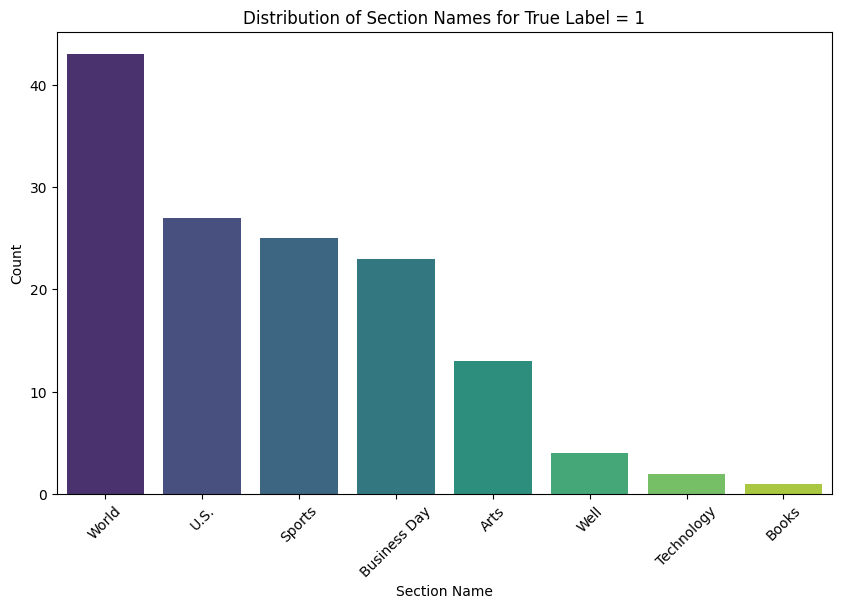

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming misclassified_df is your DataFrame
section_name_counts = df[df['True Label'] == 1]['Section Name'].value_counts().reset_index()
section_name_counts.columns = ['Section Name', 'Count']

# Plot the histogram
plt.figure(figsize=(10, 6))
sns.barplot(x='Section Name', y='Count', data=section_name_counts, palette='viridis')
plt.xlabel('Section Name')
plt.ylabel('Count')
plt.title('Distribution of Section Names for True Label = 1')
plt.xticks(rotation=45)
plt.show()


<ipython-input-55-43b6d35904d0>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Section Name', y='Count', data=section_name_counts, palette='viridis')


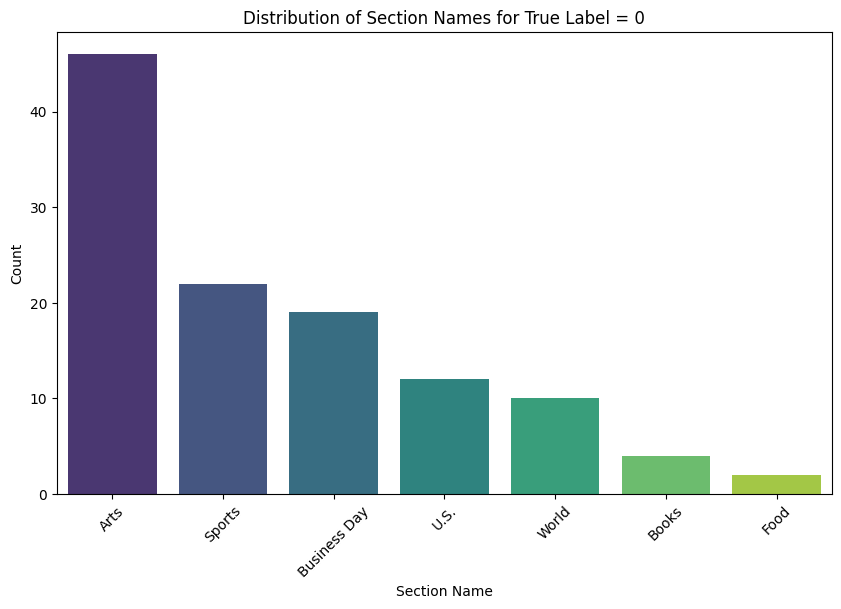

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming misclassified_df is your DataFrame
section_name_counts = df[df['True Label'] == 0]['Section Name'].value_counts().reset_index()
section_name_counts.columns = ['Section Name', 'Count']

# Plot the histogram
plt.figure(figsize=(10, 6))
sns.barplot(x='Section Name', y='Count', data=section_name_counts, palette='viridis')
plt.xlabel('Section Name')
plt.ylabel('Count')
plt.title('Distribution of Section Names for True Label = 0')
plt.xticks(rotation=45)
plt.show()


<ipython-input-57-afc1002229e4>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Type of Material', y='Count', data=section_name_counts, palette='viridis')


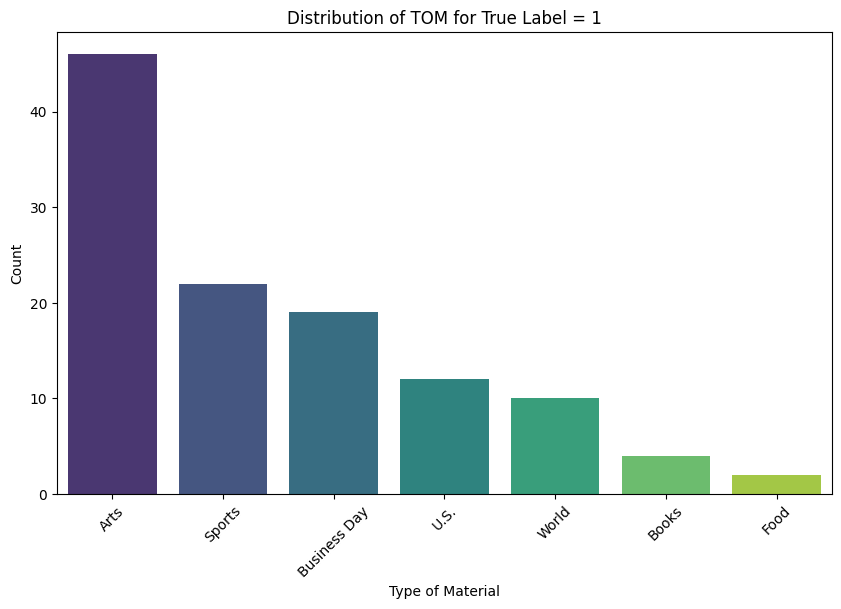

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming misclassified_df is your DataFrame
type_material = df[df['True Label'] == 1]['Type of Material'].value_counts().reset_index()
section_name_counts.columns = ['Type of Material', 'Count']

# Plot the histogram
plt.figure(figsize=(10, 6))
sns.barplot(x='Type of Material', y='Count', data=section_name_counts, palette='viridis')
plt.xlabel('Type of Material')
plt.ylabel('Count')
plt.title('Distribution of TOM for True Label = 1')
plt.xticks(rotation=45)
plt.show()


<ipython-input-61-0a6d1368cf46>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Type of Material', y='Count', data=type_material, palette='viridis')


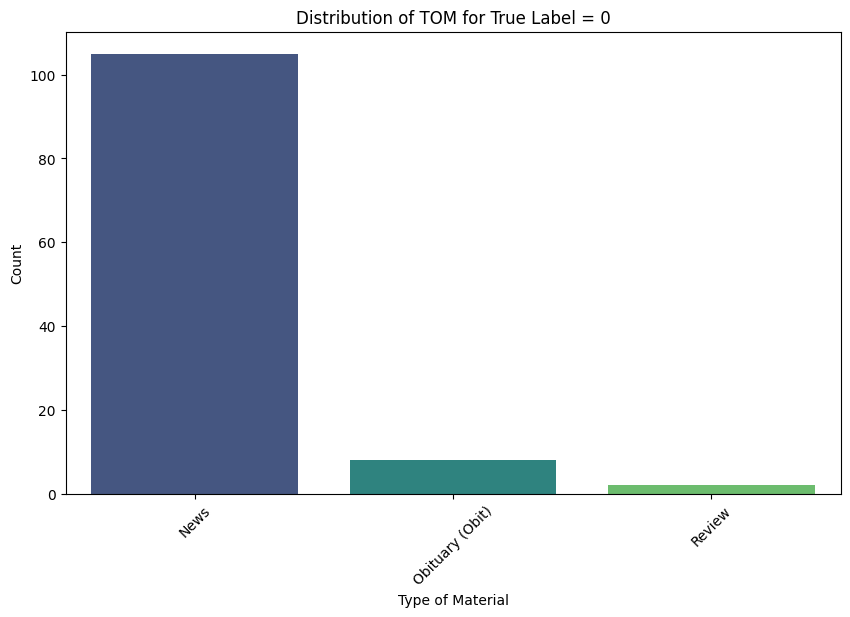

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming misclassified_df is your DataFrame
type_material = df[df['True Label'] == 0]['Type of Material'].value_counts().reset_index()
type_material.columns = ['Type of Material', 'Count']

# Plot the histogram
plt.figure(figsize=(10, 6))
sns.barplot(x='Type of Material', y='Count', data=type_material, palette='viridis')
plt.xlabel('Type of Material')
plt.ylabel('Count')
plt.title('Distribution of TOM for True Label = 0')
plt.xticks(rotation=45)
plt.show()


In [ ]:
df

,Index,Section Name,News Desk,Type of Material,Word Count,Num Subjects,Num Persons,Num Glocs,Document Vector Mean,True Label,Predicted Label
0,4,Sports,Sports,News,1341.0,4.0,1.0,1,None,1.0,0
1,11,Sports,Sports,News,1461.0,3.0,1.0,0,None,1.0,0
2,21,U.S.,Washington,News,1600.0,2.0,1.0,0,None,1.0,0
3,26,Sports,Sports,News,1104.0,3.0,1.0,0,None,1.0,0
4,29,U.S.,Washington,News,1129.0,4.0,0.0,0,None,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...
248,5037,Business Day,Business,News,1175.0,11.0,0.0,6,None,1.0,0
249,5041,World,Foreign,News,1232.0,3.0,0.0,1,None,0.0,1
250,5042,World,Foreign,News,1099.0,3.0,0.0,2,None,1.0,0
251,5045,World,Foreign,News,1252.0,2.0,0.0,1,None,1.0,0


<ipython-input-72-e042c5424ae7>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='True Label', y='Num Glocs', data=df, palette='viridis')


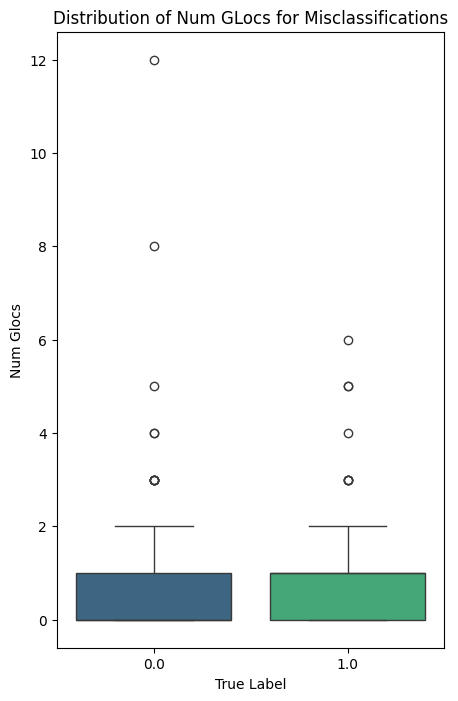

In [ ]:
# prompt: box plot of word_count misclassifications for each type

import matplotlib.pyplot as plt
# Create the box plot
plt.figure(figsize=(5, 8))
sns.boxplot(x='True Label', y='Num Glocs', data=df, palette='viridis')
plt.xlabel('True Label')
plt.ylabel('Num Glocs')
plt.title('Distribution of Num GLocs for Misclassifications')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━

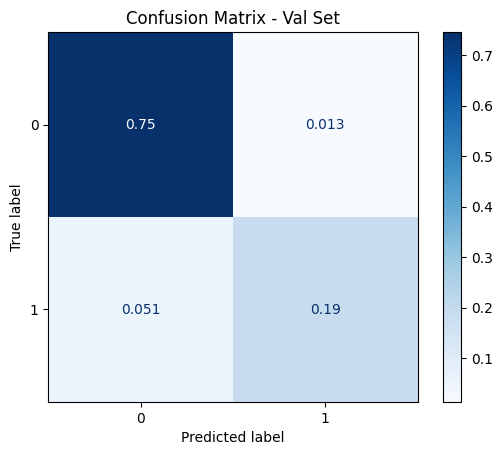

In [ ]:
model_scores=[]
def calculate_scores(y_true, y_pred):
    report = classification_report(y_true, y_pred, output_dict=True)
    precision = report['macro avg']['precision']
    recall = report['macro avg']['recall']
    f1 = report['macro avg']['f1-score']
    accuracy = report['accuracy']
    return precision, recall, f1, accuracy
# Initialize lists for collecting true labels and predictions
y_val_true_list = []
y_val_pred_list = []

# Collect true labels and predictions from the validation generator
for batch_x, batch_y in val_generator:
    batch_pred = model.predict(batch_x)
    y_val_true_list.extend(batch_y)
    y_val_pred_list.extend((batch_pred > 0.5).astype(int))

# Convert lists to numpy arrays
y_val_true = np.array(y_val_true_list)
y_val_pred = np.array(y_val_pred_list)
y_val_true = np.array(y_val_true_list).ravel()
y_val_pred = np.squeeze(np.array(y_val_pred_list))

# Calculate scores
precision, recall, f1, accuracy = calculate_scores(y_val_true, y_val_pred)
model_scores.append((model, precision, recall, f1, accuracy))

cm = confusion_matrix(y_val_true_list, y_val_pred_list,normalize='all')

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Val Set")
plt.show()


# Test evaluation

In [ ]:
test_docs = [
    TaggedDocument(doc, [i]) for i, doc in enumerate(test["combined_text"])
]

test_dm_vecs=[]
for doc_id in range(len(test_docs)):
    test_dm_vecs.append(dm_mod_tr.infer_vector(test_docs[doc_id].words))



test_dbow_vecs=[]
for doc_id in range(len(test_docs)):
    test_dbow_vecs.append(dboww_mod_tr.infer_vector(test_docs[doc_id].words))
test['dm_vec'] = [list(row) for row in test_dm_vecs]
test['dbow_vec'] = [list(row) for row in test_dbow_vecs]
test['dv_mean'] = test.apply(lambda row: np.mean([np.array(row['dm_vec']), np.array(row['dbow_vec'])], axis=0), axis=1)



In [ ]:
test.reset_index(inplace=True,drop=True)
X_test = test.drop(columns=['target'])
y_test = test['target']

X_te=X_test[['section_name','news_desk','type_of_material',
         'word_count', 'num_subjects','num_persons','num_glocs',
          'dv_mean']]

In [ ]:
test_generator = BalancedSequenceGenerator(X_te, y_test, batch_size=20, sequence_length=14, balance=False)


In [ ]:
history = model.evaluate(test_generator)

 56/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9279 - loss: 0.2133 - precision: 0.9985 - recall: 0.9168

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9417 - loss: 0.1705 - precision: 0.9840 - recall: 0.9160


In [ ]:
model = build_model(seq_length= 14, num_features=num_feat)

# Print model summary to verify input shape and architecture
model.summary()


history = model.fit(
    train_generator_reg,
    validation_data=test_generator,
    epochs=5,
    verbose=1
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ batch_normalization                  │ (None, 14, 57)              │             228 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 20)                  │           4,740 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 20)                  │             420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,409 (21.13 KB)

 Trainable params: 5,295 (20.68 KB)

 Non-trainable params: 114 (456.00 B)

Epoch 1/5
6722/6722 ━━━━━━━━━━━━━━━━━━━━ 53s 8ms/step - accuracy: 0.8749 - loss: 0.2896 - precision: 0.8597 - recall: 0.8155 - val_accuracy: 0.9623 - val_loss: 0.1013 - val_precision: 0.9459 - val_recall: 0.9202
Epoch 2/5
6722/6722 ━━━━━━━━━━━━━━━━━━━━ 50s 7ms/step - accuracy: 0.9491 - loss: 0.1366 - precision: 0.9449 - recall: 0.9281 - val_accuracy: 0.9662 - val_loss: 0.1008 - val_precision: 0.9545 - val_recall: 0.9253
Epoch 3/5
6722/6722 ━━━━━━━━━━━━━━━━━━━━ 50s 7ms/step - accuracy: 0.9595 - loss: 0.1101 - precision: 0.9564 - recall: 0.9423 - val_accuracy: 0.9618 - val_loss: 0.1143 - val_precision: 0.9458 - val_recall: 0.9185
Epoch 4/5
6722/6722 ━━━━━━━━━━━━━━━━━━━━ 49s 7ms/step - accuracy: 0.9640 - loss: 0.1002 - precision: 0.9601 - recall: 0.9486 - val_accuracy: 0.9613 - val_loss: 0.1188 - val_precision: 0.9442 - val_recall: 0.9185
Epoch 5/5
6722/6722 ━━━━━━━━━━━━━━━━━━━━ 48s 7ms/step - accuracy: 0.9653 - loss: 0.0944 - precision: 0.9622 - recall: 0.9515 - val_accuracy: 0.9604 - va

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━

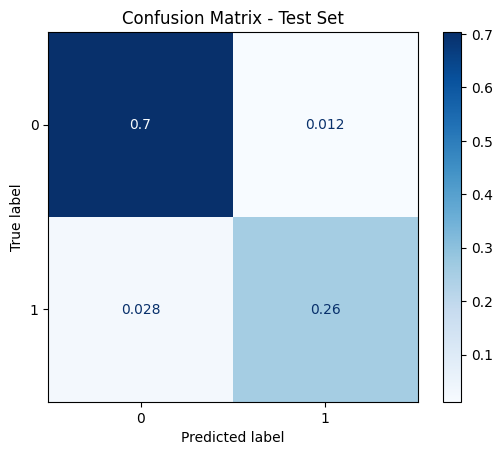

In [ ]:
model_scores=[]
def calculate_scores(y_true, y_pred):
    report = classification_report(y_true, y_pred, output_dict=True)
    precision = report['macro avg']['precision']
    recall = report['macro avg']['recall']
    f1 = report['macro avg']['f1-score']
    accuracy = report['accuracy']
    return precision, recall, f1, accuracy
# Initialize lists for collecting true labels and predictions
y_test_true_list = []
y_test_pred_list = []

# Collect true labels and predictions from the validation generator
for batch_x, batch_y in test_generator:
    batch_pred = model.predict(batch_x)
    y_test_true_list.extend(batch_y)
    y_test_pred_list.extend((batch_pred > 0.5).astype(int))

# Convert lists to numpy arrays
y_test_true = np.array(y_test_true_list)
y_test_pred = np.array(y_test_pred_list)
y_test_true = np.array(y_test_true_list).ravel()
y_test_pred = np.squeeze(np.array(y_test_pred_list))

# Calculate scores
precision, recall, f1, accuracy = calculate_scores(y_test_true, y_test_pred)
model_scores.append((model, precision, recall, f1, accuracy))

cm = confusion_matrix(y_test_true_list, y_test_pred_list,normalize='all')

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Test Set")
plt.show()
